## Load in the data
    Since the data is a .db, which is a sqlite database. We will convert the tables to pandas dataframe as required. Since the table sizes arent too big we can use pandas dataframes.

In [3]:
import sqlite3
import pandas as pd

In [4]:
# Read sqlite query results into a pandas DataFrame
sql_conn = sqlite3.connect("sqlite.db")
exec_df = pd.read_sql_query("SELECT * from exec", sql_conn)
sql_conn.close()

In [5]:
exec_df.head()

,ts,exe,pid,ppid,path,docker,depth,rates
0,0.690,sh,28531,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.2}"
1,0.696,lpstat,28532,28531,/usr/bin/lpstat,None,-1,"{""1"": 2.0, ""5"": 0.4}"
2,0.701,sed,28533,28531,/bin/sed,None,-1,"{""1"": 3.0, ""5"": 0.6}"
3,1.704,sh,28534,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.8}"
4,1.711,sed,28536,28534,sed,None,-1,"{""1"": 2.0, ""5"": 1.0}"


In [6]:
exec_df[exec_df.docker.notnull()].head()

,ts,exe,pid,ppid,path,docker,depth,rates
82,22.574,crawl.sh,28647,28628,/webcrawl/crawl.sh,/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,5,"{""1"": 1.0, ""5"": 0.2}"
83,22.604,python,28668,28647,python,/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,5,"{""1"": 2.0, ""5"": 0.4}"
84,22.936,python,28669,28647,/usr/bin/python,/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,5,"{""1"": 3.0, ""5"": 0.6}"
88,23.374,python,28673,28647,/usr/bin/python,/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,5,"{""1"": 4.0, ""5"": 0.8}"
92,24.167,python,28679,28647,/usr/bin/python,/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,5,"{""1"": 2.0, ""5"": 1.0}"


We need to split the json in rate column into two seperate columns, 'rate1s' and 'rate5s'.
    1. Use rates column to create a dataframe of 2 columns 'rate1s', 'rate5s'.
    2. Concat the dataframe from step 1 with exec_df to get the final clean dtaframe.

In [7]:
# Split rates column into two columns
rates_df = exec_df['rates'].apply(lambda x : dict(eval(x)) ).apply(pd.Series)
rates_df.columns = ['rate1s', 'rate5s']

In [8]:
rates_df.head()

,rate1s,rate5s
0,1.0,0.2
1,2.0,0.4
2,3.0,0.6
3,1.0,0.8
4,2.0,1.0


In [9]:
# Concat this with exec_df to get the entire dataset
exec_clean = pd.concat([exec_df, rates_df], axis=1)

In [10]:
exec_clean.head()

,ts,exe,pid,ppid,path,docker,depth,rates,rate1s,rate5s
0,0.690,sh,28531,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.2}",1.0,0.2
1,0.696,lpstat,28532,28531,/usr/bin/lpstat,None,-1,"{""1"": 2.0, ""5"": 0.4}",2.0,0.4
2,0.701,sed,28533,28531,/bin/sed,None,-1,"{""1"": 3.0, ""5"": 0.6}",3.0,0.6
3,1.704,sh,28534,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.8}",1.0,0.8
4,1.711,sed,28536,28534,sed,None,-1,"{""1"": 2.0, ""5"": 1.0}",2.0,1.0


# 1. Visualization
    We start of with visualizing our data. Visualization can provide a holistic view of our data, helping us further our understanding of the dataset.
    
    Start of with importing visualization libraries

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

## Plot depth
    What is depth? 

In [12]:
# Numerical distribution of depth
exec_clean['depth'].value_counts()

-1    1709
 5     790
 2       2
 3       1
 4       1
Name: depth, dtype: int64

Looking at the distribution of the data, we can see that this type of data can be easily visualized using a scatter plot

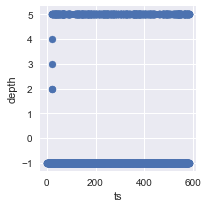

In [13]:
g = sns.FacetGrid(exec_clean)  
g.map(plt.scatter, "ts", "depth")  

In [14]:
exec_clean[(exec_clean.depth >= 2) & (exec_clean.depth <= 4)]

,ts,exe,pid,ppid,path,docker,depth,rates,rate1s,rate5s
67,22.069,auplink,28606,917,/sbin/auplink,None,2,"{""1"": 5.0, ""5"": 3.4}",5.0,3.4
68,22.107,auplink,28607,917,auplink,None,2,"{""1"": 6.0, ""5"": 3.6}",6.0,3.6
77,22.221,docker-containe,28628,1051,/usr/bin/docker-containerd-shim,None,3,"{""1"": 15.0, ""5"": 5.4}",15.0,5.4
78,22.228,docker-runc,28633,28628,/usr/bin/docker-runc,None,4,"{""1"": 16.0, ""5"": 5.6}",16.0,5.6


### interesting because all these outliers occur near 22s time, ideal to zoom in on this time scale

(-1, 5)

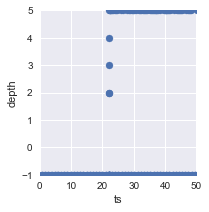

In [15]:
g = sns.FacetGrid(exec_clean)  
g.map(plt.scatter, "ts", "depth")  
plt.xlim(0, 50)  
plt.ylim(-1, 5) 

##### Thoughts
    1. the depth has -1 from the start of time, but at time ~ 22 there are a few depth outliers and then they vanish as time goes by.
    2. The value of '-1' for depth might be just a default value for no docker. Because the depth is '-1' only when docker column is empty.

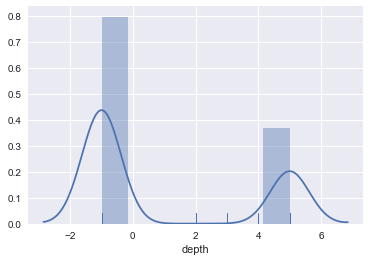

In [16]:
# histogram
sns.distplot(exec_clean['depth'], kde=True, rug=True)

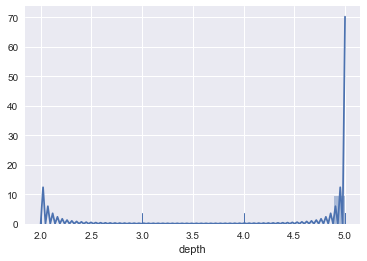

In [17]:
# histogram after removing default depth
sns.distplot(exec_clean[exec_clean.depth != -1]['depth'], kde=True, rug=True)

## Plot Rate1s


In [18]:
# rate1s numerical distribution
exec_clean['rate1s'].value_counts()

3.0     830
2.0     775
1.0     686
4.0     183
5.0      11
17.0      2
16.0      2
6.0       2
18.0      2
8.0       1
7.0       1
19.0      1
9.0       1
11.0      1
12.0      1
13.0      1
14.0      1
15.0      1
10.0      1
Name: rate1s, dtype: int64

In [19]:
exec_clean[(exec_clean.rate1s > 5)].sort_values(by='depth')

,ts,exe,pid,ppid,path,docker,depth,rates,rate1s,rate5s
76,22.199,systemd-sysctl,28624,28614,/lib/systemd/systemd-sysctl,None,-1,"{""1"": 14.0, ""5"": 5.2}",14.0,5.2
86,23.047,sed,28672,28670,sed,None,-1,"{""1"": 17.0, ""5"": 6.0}",17.0,6.0
85,23.035,sh,28670,1158,sh,None,-1,"{""1"": 16.0, ""5"": 5.8}",16.0,5.8
87,23.052,lpstat,28671,28670,/usr/bin/lpstat,None,-1,"{""1"": 18.0, ""5"": 6.2}",18.0,6.2
75,22.188,ifquery,28619,-1,/sbin/ifquery,None,-1,"{""1"": 13.0, ""5"": 5.0}",13.0,5.0
74,22.187,systemd-sysctl,28623,28613,/lib/systemd/systemd-sysctl,None,-1,"{""1"": 12.0, ""5"": 4.8}",12.0,4.8
593,138.300,01ifupdown,29195,29191,/etc/NetworkManager/dispatcher.d/01ifupdown,None,-1,"{""1"": 6.0, ""5"": 3.6}",6.0,3.6
72,22.164,ifquery,28622,-1,/sbin/ifquery,None,-1,"{""1"": 10.0, ""5"": 4.4}",10.0,4.4
71,22.159,ifquery,28617,28615,/sbin/ifquery,None,-1,"{""1"": 9.0, ""5"": 4.2}",9.0,4.2
70,22.159,ifquery,28621,-1,/sbin/ifquery,None,-1,"{""1"": 8.0, ""5"": 4.0}",8.0,4.0


Again we see a lot of outliers of rate1s aroung the 22 time, and there is a lot of overlap with depth=-1 values. 
We can see a few outliers from the distribution of rate1s, we can try using scatter plot here as well

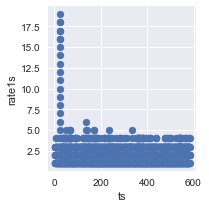

In [20]:
g = sns.FacetGrid(exec_clean)  
g.map(plt.scatter, "ts", "rate1s")  

Zoom in

(-1, 20)

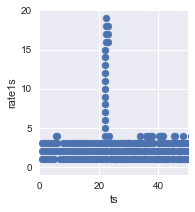

In [21]:
g = sns.FacetGrid(exec_clean)  
g.map(plt.scatter, "ts", "rate1s")  
plt.xlim(0, 50)  
plt.ylim(-1, 20) 

These outliers occur at around 22t as well.

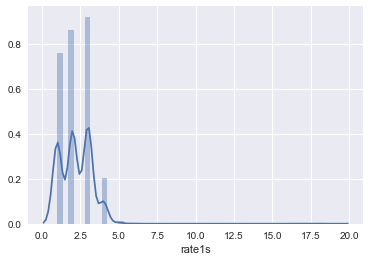

In [22]:
# histogram
sns.distplot(exec_clean['rate1s'], kde=True);

In [23]:
# rate1s numerical distribution
exec_clean['rate5s'].value_counts()

2.8    606
2.6    598
3.0    451
2.4    170
2.0     93
1.6     92
1.8     89
2.2     86
1.4     60
1.2     50
1.0     47
0.8     44
0.6     35
0.4     20
3.2     11
0.2     10
3.4     10
6.2      5
5.8      5
6.0      5
3.6      3
5.2      2
5.4      2
5.6      2
4.2      1
4.6      1
4.4      1
3.8      1
5.0      1
4.0      1
4.8      1
Name: rate5s, dtype: int64

In [24]:
exec_clean[(exec_clean.rate1s > 5)].sort_values(by='depth')

,ts,exe,pid,ppid,path,docker,depth,rates,rate1s,rate5s
76,22.199,systemd-sysctl,28624,28614,/lib/systemd/systemd-sysctl,None,-1,"{""1"": 14.0, ""5"": 5.2}",14.0,5.2
86,23.047,sed,28672,28670,sed,None,-1,"{""1"": 17.0, ""5"": 6.0}",17.0,6.0
85,23.035,sh,28670,1158,sh,None,-1,"{""1"": 16.0, ""5"": 5.8}",16.0,5.8
87,23.052,lpstat,28671,28670,/usr/bin/lpstat,None,-1,"{""1"": 18.0, ""5"": 6.2}",18.0,6.2
75,22.188,ifquery,28619,-1,/sbin/ifquery,None,-1,"{""1"": 13.0, ""5"": 5.0}",13.0,5.0
74,22.187,systemd-sysctl,28623,28613,/lib/systemd/systemd-sysctl,None,-1,"{""1"": 12.0, ""5"": 4.8}",12.0,4.8
593,138.300,01ifupdown,29195,29191,/etc/NetworkManager/dispatcher.d/01ifupdown,None,-1,"{""1"": 6.0, ""5"": 3.6}",6.0,3.6
72,22.164,ifquery,28622,-1,/sbin/ifquery,None,-1,"{""1"": 10.0, ""5"": 4.4}",10.0,4.4
71,22.159,ifquery,28617,28615,/sbin/ifquery,None,-1,"{""1"": 9.0, ""5"": 4.2}",9.0,4.2
70,22.159,ifquery,28621,-1,/sbin/ifquery,None,-1,"{""1"": 8.0, ""5"": 4.0}",8.0,4.0


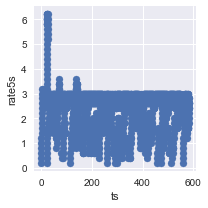

In [25]:
g = sns.FacetGrid(exec_clean)  
g.map(plt.scatter, "ts", "rate5s")  

(-1, 10)

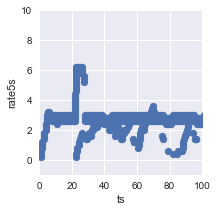

In [26]:
g = sns.FacetGrid(exec_clean)  
g.map(plt.scatter, "ts", "rate5s")  
plt.xlim(0, 100)  
plt.ylim(-1, 10) 

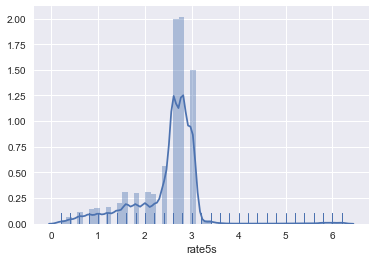

In [27]:
# histogram
sns.distplot(exec_clean['rate5s'], kde=True, rug=True);

### Time scale plot

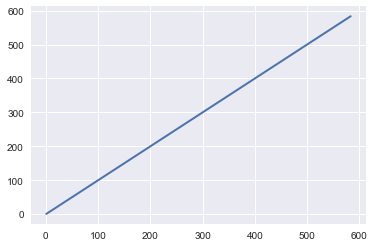

In [28]:
plt.plot(exec_clean['ts'], exec_clean['ts'], linewidth=2)

In [39]:
def display_plot_hist(input_df, x, y, x_lim=0, y_lim=0):
    """
    Function to display a scatter plot and histogram given a dataframe and the corresponding X and Y axis
    
    @Param:
        input_df: the input dataframe
        x: the name of the column to be considered the x axis
        y: the name of the column to be considered the y axis
        x_lim: the x axis limits, pass as list (optional)
        y_lim: the y axis limit, pass as list (optional)
    
    @Return:
        None
    """
    # Display Scatter plot
    plt.figure()
    #g = sns.FacetGrid(input_df)  
    #g.map(plt.scatter, x, y)  
    #fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    sns.lmplot(x, y, data=input_df, fit_reg=False)
    if x_lim != 0:
        plt.xlim(x_lim)  
        plt.ylim(y_lim) 
    # Histogram
    plt.figure()
    sns.distplot(input_df[y], kde=True, rug=True)

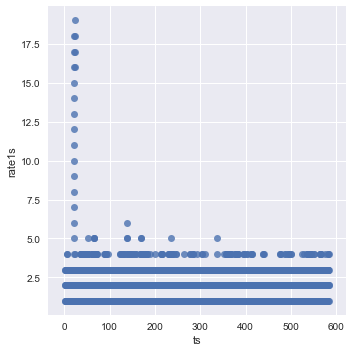

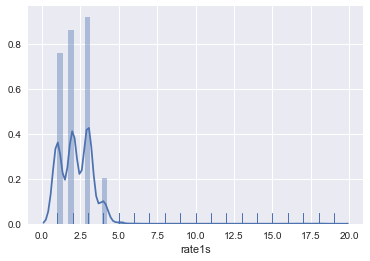

In [40]:
display_plot_hist(input_df=exec_clean, x='ts', y='rate1s')

In [41]:
# Read sqlite query results into a pandas DataFrame
sql_conn = sqlite3.connect("sqlite.db")
tcp_df = pd.read_sql_query("SELECT * from tcplife", sql_conn)
sql_conn.close()

In [42]:
tcp_df.head()

,ts,pid,lport,rport,rx,tx,dur,histotimes,histosizes,histoports,docker,prediction,predquality
0,25.147065,28668,60290,80,30,0,93.65,"[[0, 0, 1, 0, 0], 93.65, 93.65]","[[0, 0, 1, 0, 0], 30, 30]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-11.362980,1
1,25.536215,28669,47054,80,166,0,192.11,"[[1, 0, 0, 0, 1], 93.65, 192.11]","[[1, 0, 0, 0, 1], 30, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-14.629130,1
2,26.039532,28673,53762,80,0,0,81.72,"[[2, 0, 0, 0, 1], 81.72, 192.11]","[[2, 0, 0, 0, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-10.452350,1
3,26.201396,28673,50248,80,0,0,25.16,"[[1, 1, 1, 0, 1], 25.16, 192.11]","[[3, 0, 0, 0, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-10.414340,1
4,26.329412,28673,57968,443,0,0,17.78,"[[2, 1, 1, 0, 1], 17.78, 192.11]","[[4, 0, 0, 0, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 1, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-23.817379,0
